[Olist Kaggle Dataset](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv)

In [ ]:
# __file__ = "1.0-pr-initial-data-exploration.ipynb"
# BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
# DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'), 'raw_data')

# files_names = [file for file in os.listdir(DATA_DIR) if file.endswith('.csv')]
# dataframes = {}
# for file_name in files_names:
#     table_name = file_name.replace("olist_", "").replace("_dataset", "").replace(".csv","")
#     dataframes[table_name] = pd.read_csv(os.path.join(DATA_DIR, file_name))
#     print(f"Loading {table_name}")    

# Business Questions. 
_We want answers!_ 

**The company's business areas have some doubts and challenges such as:**


- Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?


- Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?


- Is our product catalog comprehensive? Or does it focus on specific categories?


- Do we always sell the same products? Or are there seasonalities?



**Dashboard that analyzes the company's latest sales data that can be shared with Regional leads and their respective analysts:**

- Total Sales
- Sales per Region
- Top 5 selling categories for each Region

_delivered orders only_

# 0.0 Imports

In [82]:
import psycopg2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

from datetime import date

import dotenv
import os
from IPython.display import Image

In [328]:
# Settings
dotenv.load_dotenv(dotenv.find_dotenv(os.path.expanduser("-")))

__file__ = "1.0-pr-data-analysis-postgresql.ipynb"
THIS_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'))
DASHBOARD_DATA_DIR = os.path.join(DATA_DIR, "business_questions_insights_dashboard_data")

NOWADAY = date(2018,10,1) # PROJECT STARTING ASSUMED DATE

## 0.1 Helper Classes

In [3]:
class QueryBuilder:
    def __init__(self):
        self.select_value = ''
        self.from_table_name = ''
        self.where_value = ''
        self.groupby_value = ''
        self.limit_value = ''
        self.having_value = ''
        self.last_query_value = ''

    def select(self, select_arg):
        self.select_value = select_arg
        return self

    def from_table(self, from_arg):
        self.from_table_name = from_arg
        return self

    def where(self, where_arg):
        self.where_value = where_arg
        return self

    def groupby(self, groupby_args):
        self.groupby_value = groupby_args
        return self
    
    def having(self, having_value):
        self.having_value = having_value
    
    def limit(self, limit_args):
        self.limit_value = limit_args
        return self
    
    def reset(self):
        self.select_value = ''
        self.from_table_name = ''
        self.where_value = ''
        self.groupby_value = ''
        self.limit_value = ''
        self.having_value = ''
        return self
    
    def last_query(self):
        return self.last_query_value

    def build(self, reset=True):
        where_clause = ''
        groupby_clause = ''
        having_clause =''
        limit_clause = ''
        
        if self.where_value:
            where_clause = f'WHERE  {self.where_value}'
        if self.groupby_value:
            groupby_clause = f'GROUP BY {self.groupby_value}'
        if self.limit_value:
            limit_clause = f'LIMIT {self.limit_value}'
        if self.having_value:
            having_clause = f'HAVING {self.having_value}'

        self.last_query_value = f"""
           SELECT {self.select_value}
           FROM   {self.from_table_name}
           {where_clause}
           {groupby_clause}
           {having_clause}
           {limit_clause};
        """
        
        if reset:
            self.reset()
        
        return self.last_query_value
    
    
class PostegreSQL:
    def __init__(self, host="localhost", user="postgres", password="********", database="postgres"):
        self.conn = psycopg2.connect(host=host, user=user, password=password, database=database)
        self.cursor = self.conn.cursor()
        
    def execute(self, query):
        self.cursor.execute(query)
        return [table for table in self.cursor.fetchall()]
    
    def columns(self, table_name):
        self.cursor.execute(F"""SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}'""" )
        return [table[0] for table in self.cursor.fetchall()]
    
    def tables(self):
        self.cursor.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")
        return [table for table in self.cursor.fetchall()]
    
    def rollback(self):
        self.cursor.execute("ROLLBACK;")

## 0.2  Helper Functions

In [138]:
def db_mer_schema():
    return Image( '../images/mer.png' ) 


def to_pandas(query_result, columns):
    return pd.DataFrame(query_result, columns=columns)
    
    
def write_query(file_name, query):
    with open(f'{file_name}.sql', 'w') as file:
        file.write(query)

def read_query(path):      
    with open(f'{path}', 'r') as file:
        return file.read()
    

def fig(x=15, y=5):
    plt.figure(figsize=(x,y))
    
    
    
def map_regions(state):
    regions = {
        'north': ['AM','RR','AP','PA','TO','RO','AC'],
        'northeast': ['MA','PI','CE','RN','PE','PB','SE','AL','BA'],
        'midwest': ['MT','MS','GO','DF'],
        'southeast': ['SP','RJ','ES','MG'],
        'south': ['PR','RS','SC']
    }
    for region, states in regions.items():
        if state in states:
            return region
        
        
# Business Questions.
        
def describe_data(data):
    print(f"Shape: {data.shape}")
    print(f"Duplicates: {data.duplicated().any()}")
    
    is_na = data.isna().sum()
    is_na_percentage = data.isna().sum()/data.shape[0]*100
    nan_data_frame = pd.concat([data.dtypes, is_na, is_na_percentage], axis=1)
    nan_data_frame.columns = ['data_types', 'nan_count', 'nan_percentage']
    #display(nan_data_frame)
    return nan_data_frame

def missing_plot(data, nan_cols, no_nan_col, x=15, y=5, first_graph=True, second_graph=True):
    nan_cols.insert(0, no_nan_col)
    try:
        if first_graph:
            msno.matrix(data[nan_cols], figsize=(x, y))
            plt.show()
        if second_graph:
            msno.bar(data[nan_cols], figsize=(x, y))
            plt.show()
    except Exception as e:
        print(e)


## 0.3 Loading Data

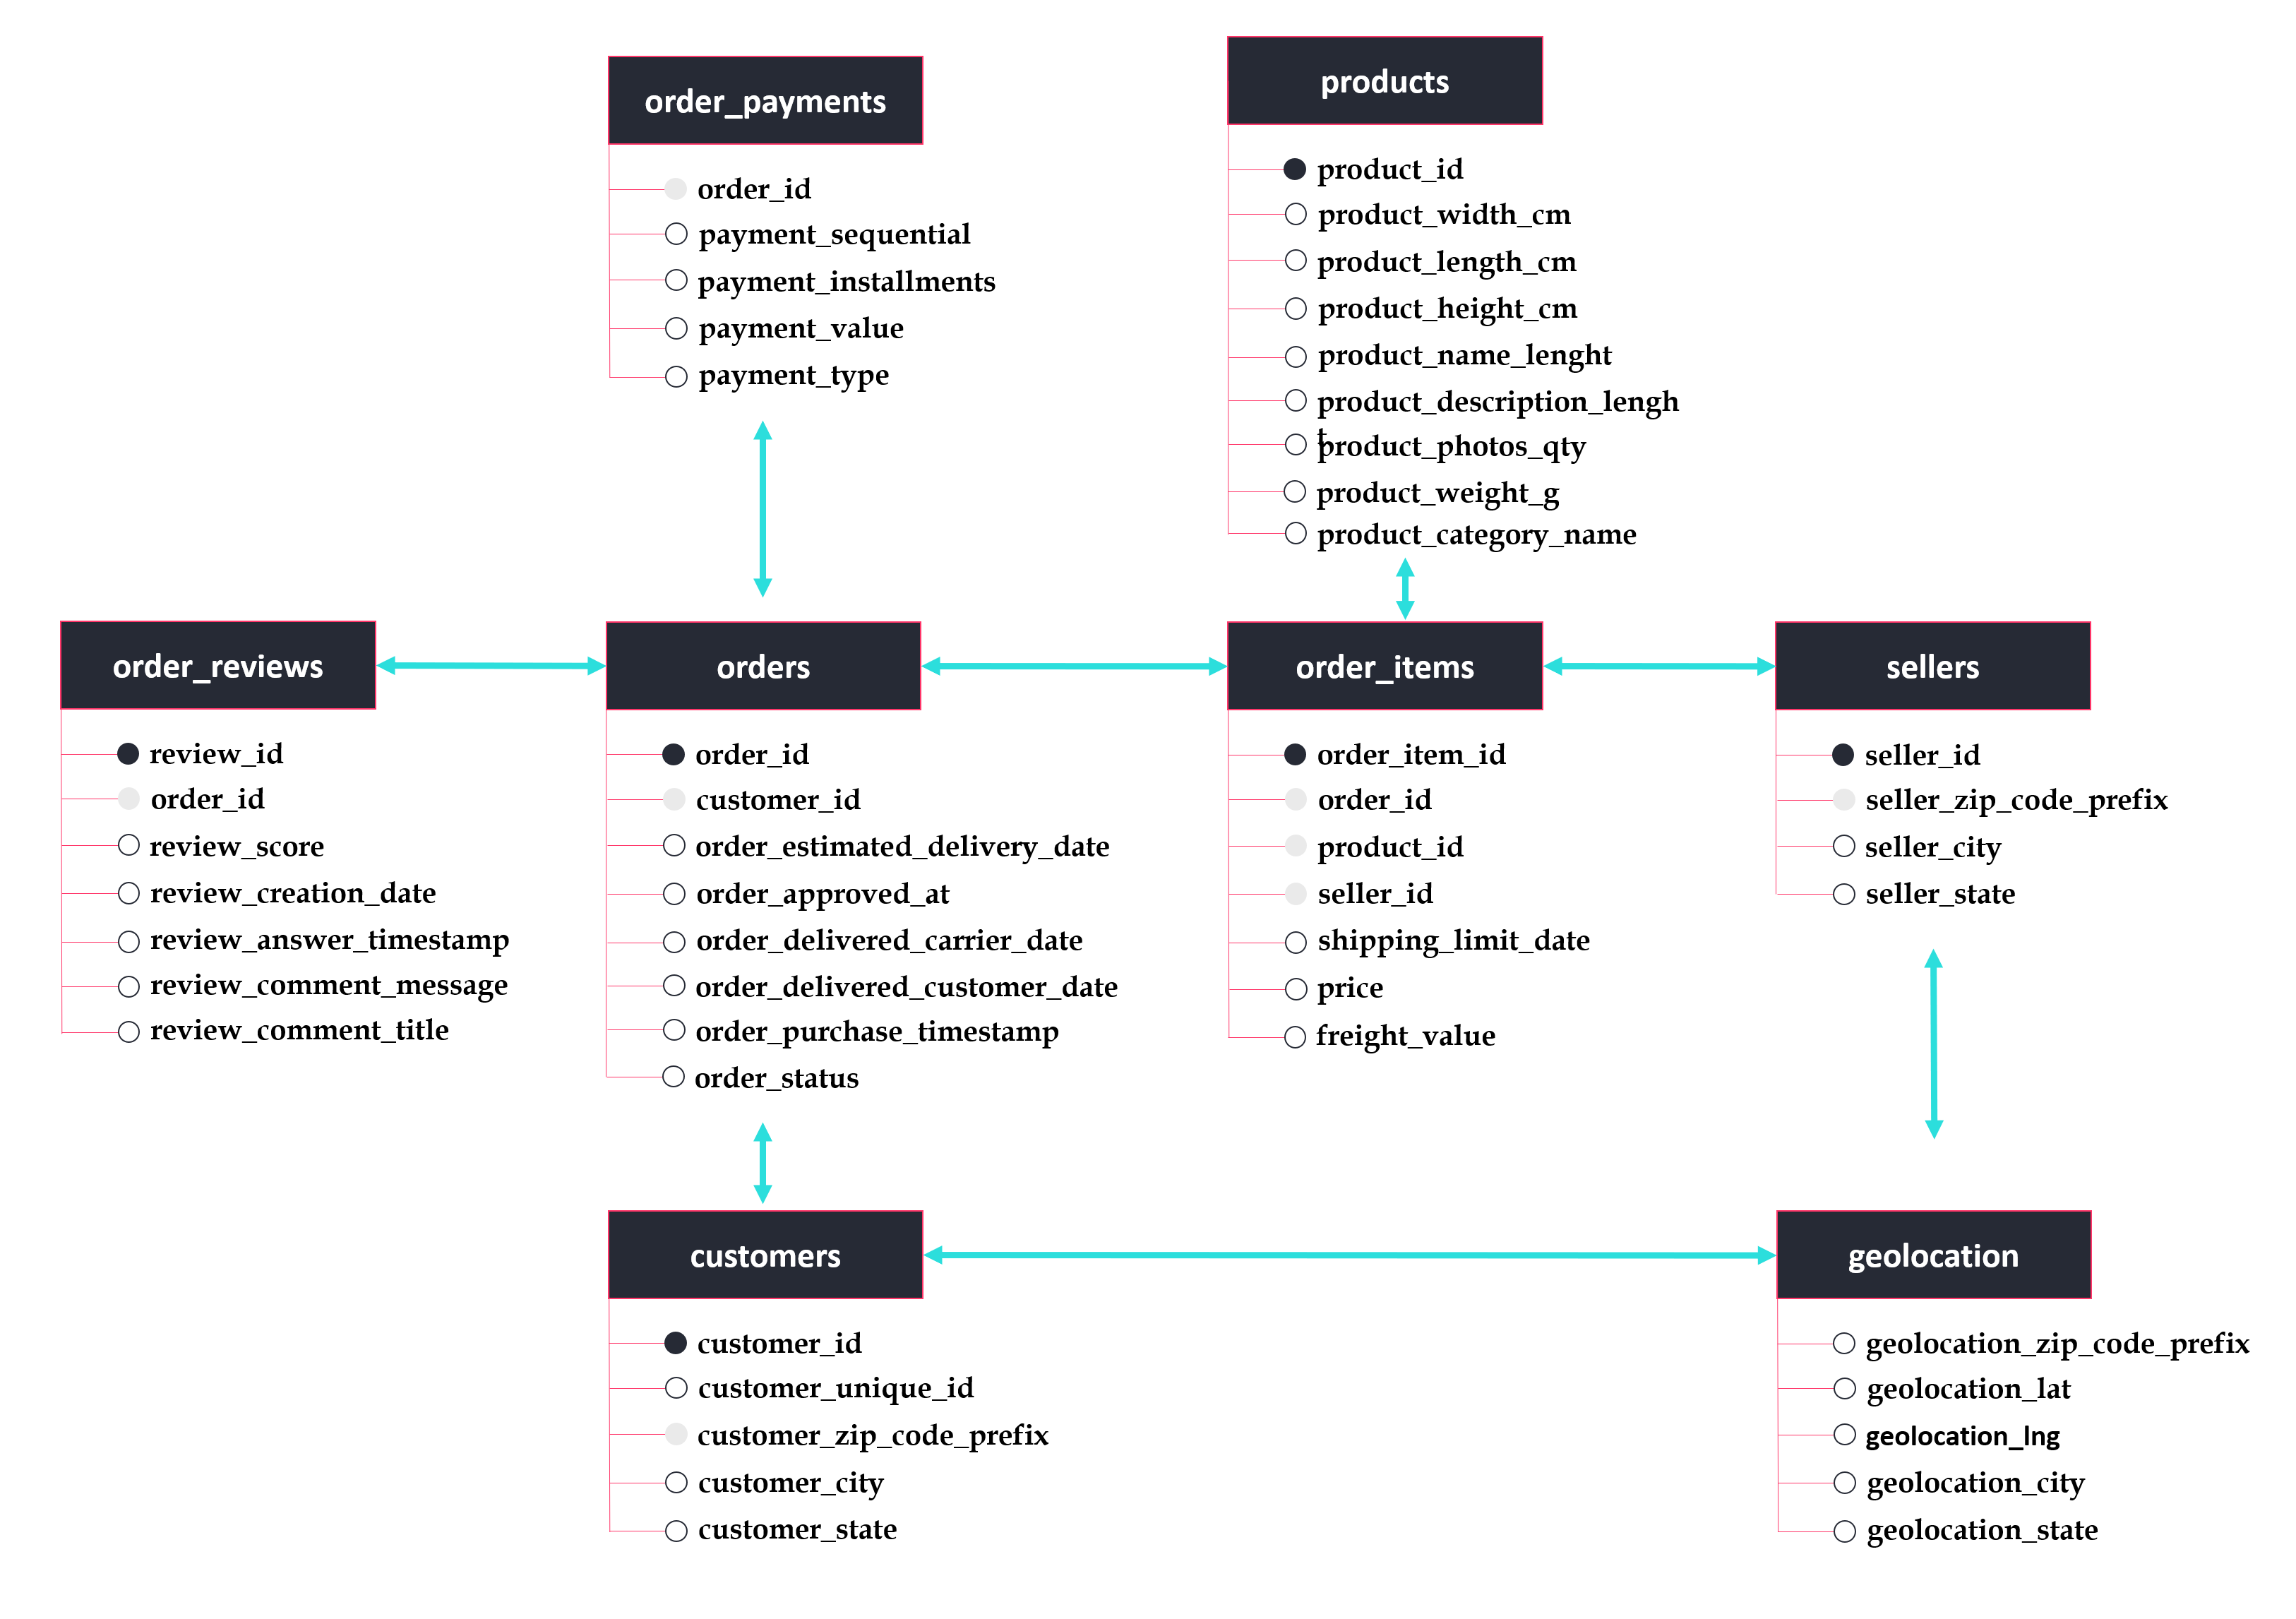

In [5]:
db_mer_schema()

<font  color='grey'>
    As my service was in stopped state somehow. "On windows, Just go to the 'Services'. Start/Restart the postgresql-X64 service".<br>
<a href='https://stackoverflow.com/questions/40532399/unable-to-connect-to-server-for-postgres' target='_blank'>stackoverflow</a>
</font>

In [6]:
db = PostegreSQL(host="localhost", user="postgres", password=os.getenv("POSTGRES_PASSWORD"), database="postgres")

In [7]:
db.tables()

[('order_items',),
 ('products',),
 ('sellers',),
 ('orders',),
 ('order_reviews',),
 ('order_payments',),
 ('geolocation',),
 ('customers',)]

## 1.0 Dashboard Queries

In [8]:
query = QueryBuilder()

### 1.1 Total Sales

_from confirmed (delivered) orders_

In [10]:
query.select("MIN(order_purchase_timestamp), MAX(order_purchase_timestamp)").from_table("orders")
to_pandas(db.execute(query.build()),['first_purchase','last_purchase'])

,first_purchase,last_purchase
0,2016-09-04 21:15:19,2018-10-17 17:30:18


In [346]:
def get_annual_sales(year):
    sales_per_month = pd.DataFrame()
    for month in range(1, 13):

        intial_date = str(date(year, month, 1))
        if month == 12:
            month = 0
            year += 1
        final_date = str(date(year, month+1, 1))
        total_sales_query = query.select("date(MIN(order_purchase_timestamp)), SUM(price)").\
                            from_table("orders LEFT JOIN order_items ON orders.order_id = order_items.order_id").\
                            where(f'''order_status='delivered' and 
                                  order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')''').\
                            build()

        sales_per_month = pd.concat([sales_per_month,to_pandas(db.execute(total_sales_query),['date','total_sales'])], axis=0)
        sales_per_month['date'] = pd.to_datetime(sales_per_month['date'])
        sales_per_month['month'] = sales_per_month['date'].dt.strftime('%b')
        
    return sales_per_month.reset_index(drop=True)

get_annual_sales(2017)

,date,total_sales,month
0,2017-01-05,111798.36,Jan
1,2017-02-01,234223.40,Feb
2,2017-03-01,359198.85,Mar
3,2017-04-01,340669.68,Apr
4,2017-05-01,489338.25,May
5,2017-06-01,421923.37,Jun
6,2017-07-01,481604.52,Jul
7,2017-08-01,554699.70,Aug
8,2017-09-01,607399.67,Sep
9,2017-10-01,648247.65,Oct


In [347]:
year = 2018
annual_sales = get_annual_sales(year).dropna()

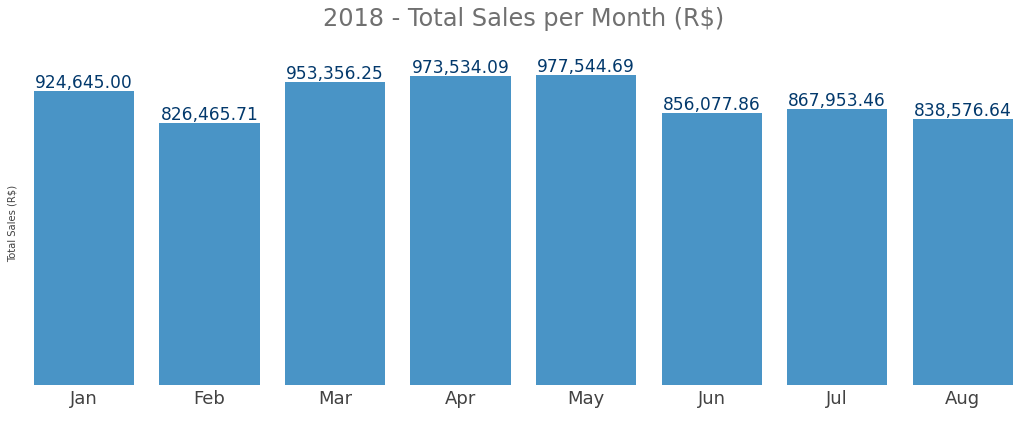

In [13]:
x = list(range(len(annual_sales['month'])))
sales = annual_sales['total_sales'].values
fig(18,6)
sns.barplot(data=annual_sales, x='month', y='total_sales', color='#3498db');

plt.box(False)
plt.title(f"{year} - Total Sales per Month (R$)\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel(" ", color='#424242')
plt.ylabel("Total Sales (R$)", color='#424242')
plt.xticks(color="#424242", size=18)
plt.yticks([],[])

for sale_value in range(len(sales)):
    plt.annotate("{:,.2f}".format(sales[sale_value]), xy=(x[sale_value],sales[sale_value]),
                 ha='center', va='bottom', size=17, color='#03396c')
plt.show()

In [14]:
annual_sales.drop(columns='month').to_csv(os.path.join(DASHBOARD_DATA_DIR, "monthly_sales_2018.csv"), index=False)

### 1.2 Sales per Region

In [14]:
def get_annual_sales(year):
    sales_per_month = pd.DataFrame()
    for month in range(1, 13):

        intial_date = str(date(year, month, 1))
        if month == 12:
            month = 0
            year += 1
        final_date = str(date(year, month+1, 1))
        total_sales_query = query.select("date(MIN(order_purchase_timestamp)), SUM(price), customer_state").\
                            from_table('''orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                                         LEFT JOIN customers ON orders.customer_id = customers.customer_id''').\
                            where(f'''order_status='delivered' and 
                                  order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')''').\
                            groupby("customers.customer_state").\
                            build()

        sales_per_month = pd.concat([sales_per_month,to_pandas(db.execute(total_sales_query),['date','total_sales','state'])], axis=0)
        sales_per_month['date'] = pd.to_datetime(sales_per_month['date'])
        sales_per_month['month'] = sales_per_month['date'].dt.strftime('%b')
        
    return sales_per_month.reset_index(drop=True)

get_annual_sales(2017).head(2)

,date,total_sales,state,month
0,2017-01-21,589.60,AC,Jan
1,2017-01-25,393.97,AL,Jan


In [15]:
region_sales_per_month = get_annual_sales(2018)

In [17]:
region_sales_per_month['region'] = region_sales_per_month.state.apply(map_regions)

In [18]:
region_sales_per_month.groupby("region").agg(['sum','mean','median']).round(2)

total_sales                      
                  sum       mean     median
region                                     
midwest     451261.13   14101.91   13309.95
north       161528.92    2936.89    1811.80
northeast   785140.40   10904.73    6866.88
south      1033757.65   43073.24   44046.22
southeast  4786465.60  149577.05  108298.86

In [177]:
region_sales_per_month['region'].unique()

array(['south', 'midwest', 'southeast', 'northeast', 'north'],
      dtype=object)

### 1.2.3 Saving Data to Dashboard

In [95]:
def monthly_sales_per_region_to_df(region_name):  
    sales = region_sales_per_month.groupby(['region','date']).sum().loc[[region_name]].values
    sales_dates = region_sales_per_month.groupby(['region','date']).sum().loc[[region_name]].index.get_level_values("date")
    return pd.concat([pd.Series(sales_dates), pd.Series(sales.ravel(), name='total_sales')], axis=1)

**midwest**

In [173]:
midwest_sales_df = monthly_sales_per_region_to_df('midwest')
midwest_sales_df.set_index("date").T

date,2018-01-01,2018-01-03,2018-02-01,2018-02-02,2018-03-01,2018-04-01,2018-04-03,2018-05-01,2018-06-01,2018-07-01,2018-07-02,2018-08-01
total_sales,44249.73,10535.7,47440.9,8172.69,53825.66,42901.31,11354.49,71272.76,52827.42,53788.38,6810.83,48081.26


In [ ]:
midwest_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "midwest_monthly_sales_2018.csv"), index=False)

**south**

In [178]:
south_sales_df = monthly_sales_per_region_to_df('south')
south_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "south_monthly_sales_2018.csv"), index=False)

**southeast**

In [180]:
southeast_sales_df = monthly_sales_per_region_to_df('southeast')
southeast_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "southeast_monthly_sales_2018.csv"), index=False)

**northeast**

In [182]:
northeast_sales_df = monthly_sales_per_region_to_df('northeast')
northeast_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "northeast_monthly_sales_2018.csv"), index=False)

**north**

In [183]:
north_sales_df = monthly_sales_per_region_to_df('north')
north_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "north_monthly_sales_2018.csv"), index=False)

### 1.3 Top 5 selling categories for each Region

In [27]:
intial_date = "2018-08-01"
final_date  = "2018-09-01"

In [28]:
sales_per_category_query = query.select("product_category_name, price, customer_state").\
                                 from_table('''orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                                               LEFT JOIN products ON products.product_id = order_items.product_id
                                               LEFT JOIN customers ON orders.customer_id = customers.customer_id''').\
                                 where(f"order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')").\
                                 build()
sales_per_category = to_pandas(db.execute(sales_per_category_query),['category','total_sales','state'])

In [31]:
sales_per_category['region'] = sales_per_category.state.apply(map_regions)

### 1.3.1 Saving Data to Dashboard

In [98]:
def _categories_sales_per_region_to_df(sales_per_category, region):
    sales = sales_per_category.groupby(["region", "category"]).sum().loc[[region]].\
            sort_values(by=['total_sales'], ascending=False).head(5).values
    categories = sales_per_category.groupby(["region", "category"]).sum().loc[[region]].\
                 sort_values(by=['total_sales'], ascending=False).head(5).index.get_level_values("category")
    categories = categories.str.replace("_"," ")
    return pd.concat([pd.Series(categories), pd.Series(sales.ravel(), name='total_sales')], axis=1)

def _save_sales_per_category_for_dashboard(sales_per_category, region):
    _categories_sales_per_region_to_df(sales_per_category, region).\
    to_csv(os.path.join(DASHBOARD_DATA_DIR, f"top_selling_categories_{region}.csv"), index=False)

In [99]:
_save_sales_per_category_for_dashboard(sales_per_category, "south")
_save_sales_per_category_for_dashboard(sales_per_category, "midwest")
_save_sales_per_category_for_dashboard(sales_per_category, "southeast")
_save_sales_per_category_for_dashboard(sales_per_category, "northeast")
_save_sales_per_category_for_dashboard(sales_per_category, "north")

## 2.0 Business Challenges

### 2.1 Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?

One form of evaluation is to give benefits based on productivity. _Sellers who sell more, more frequently._

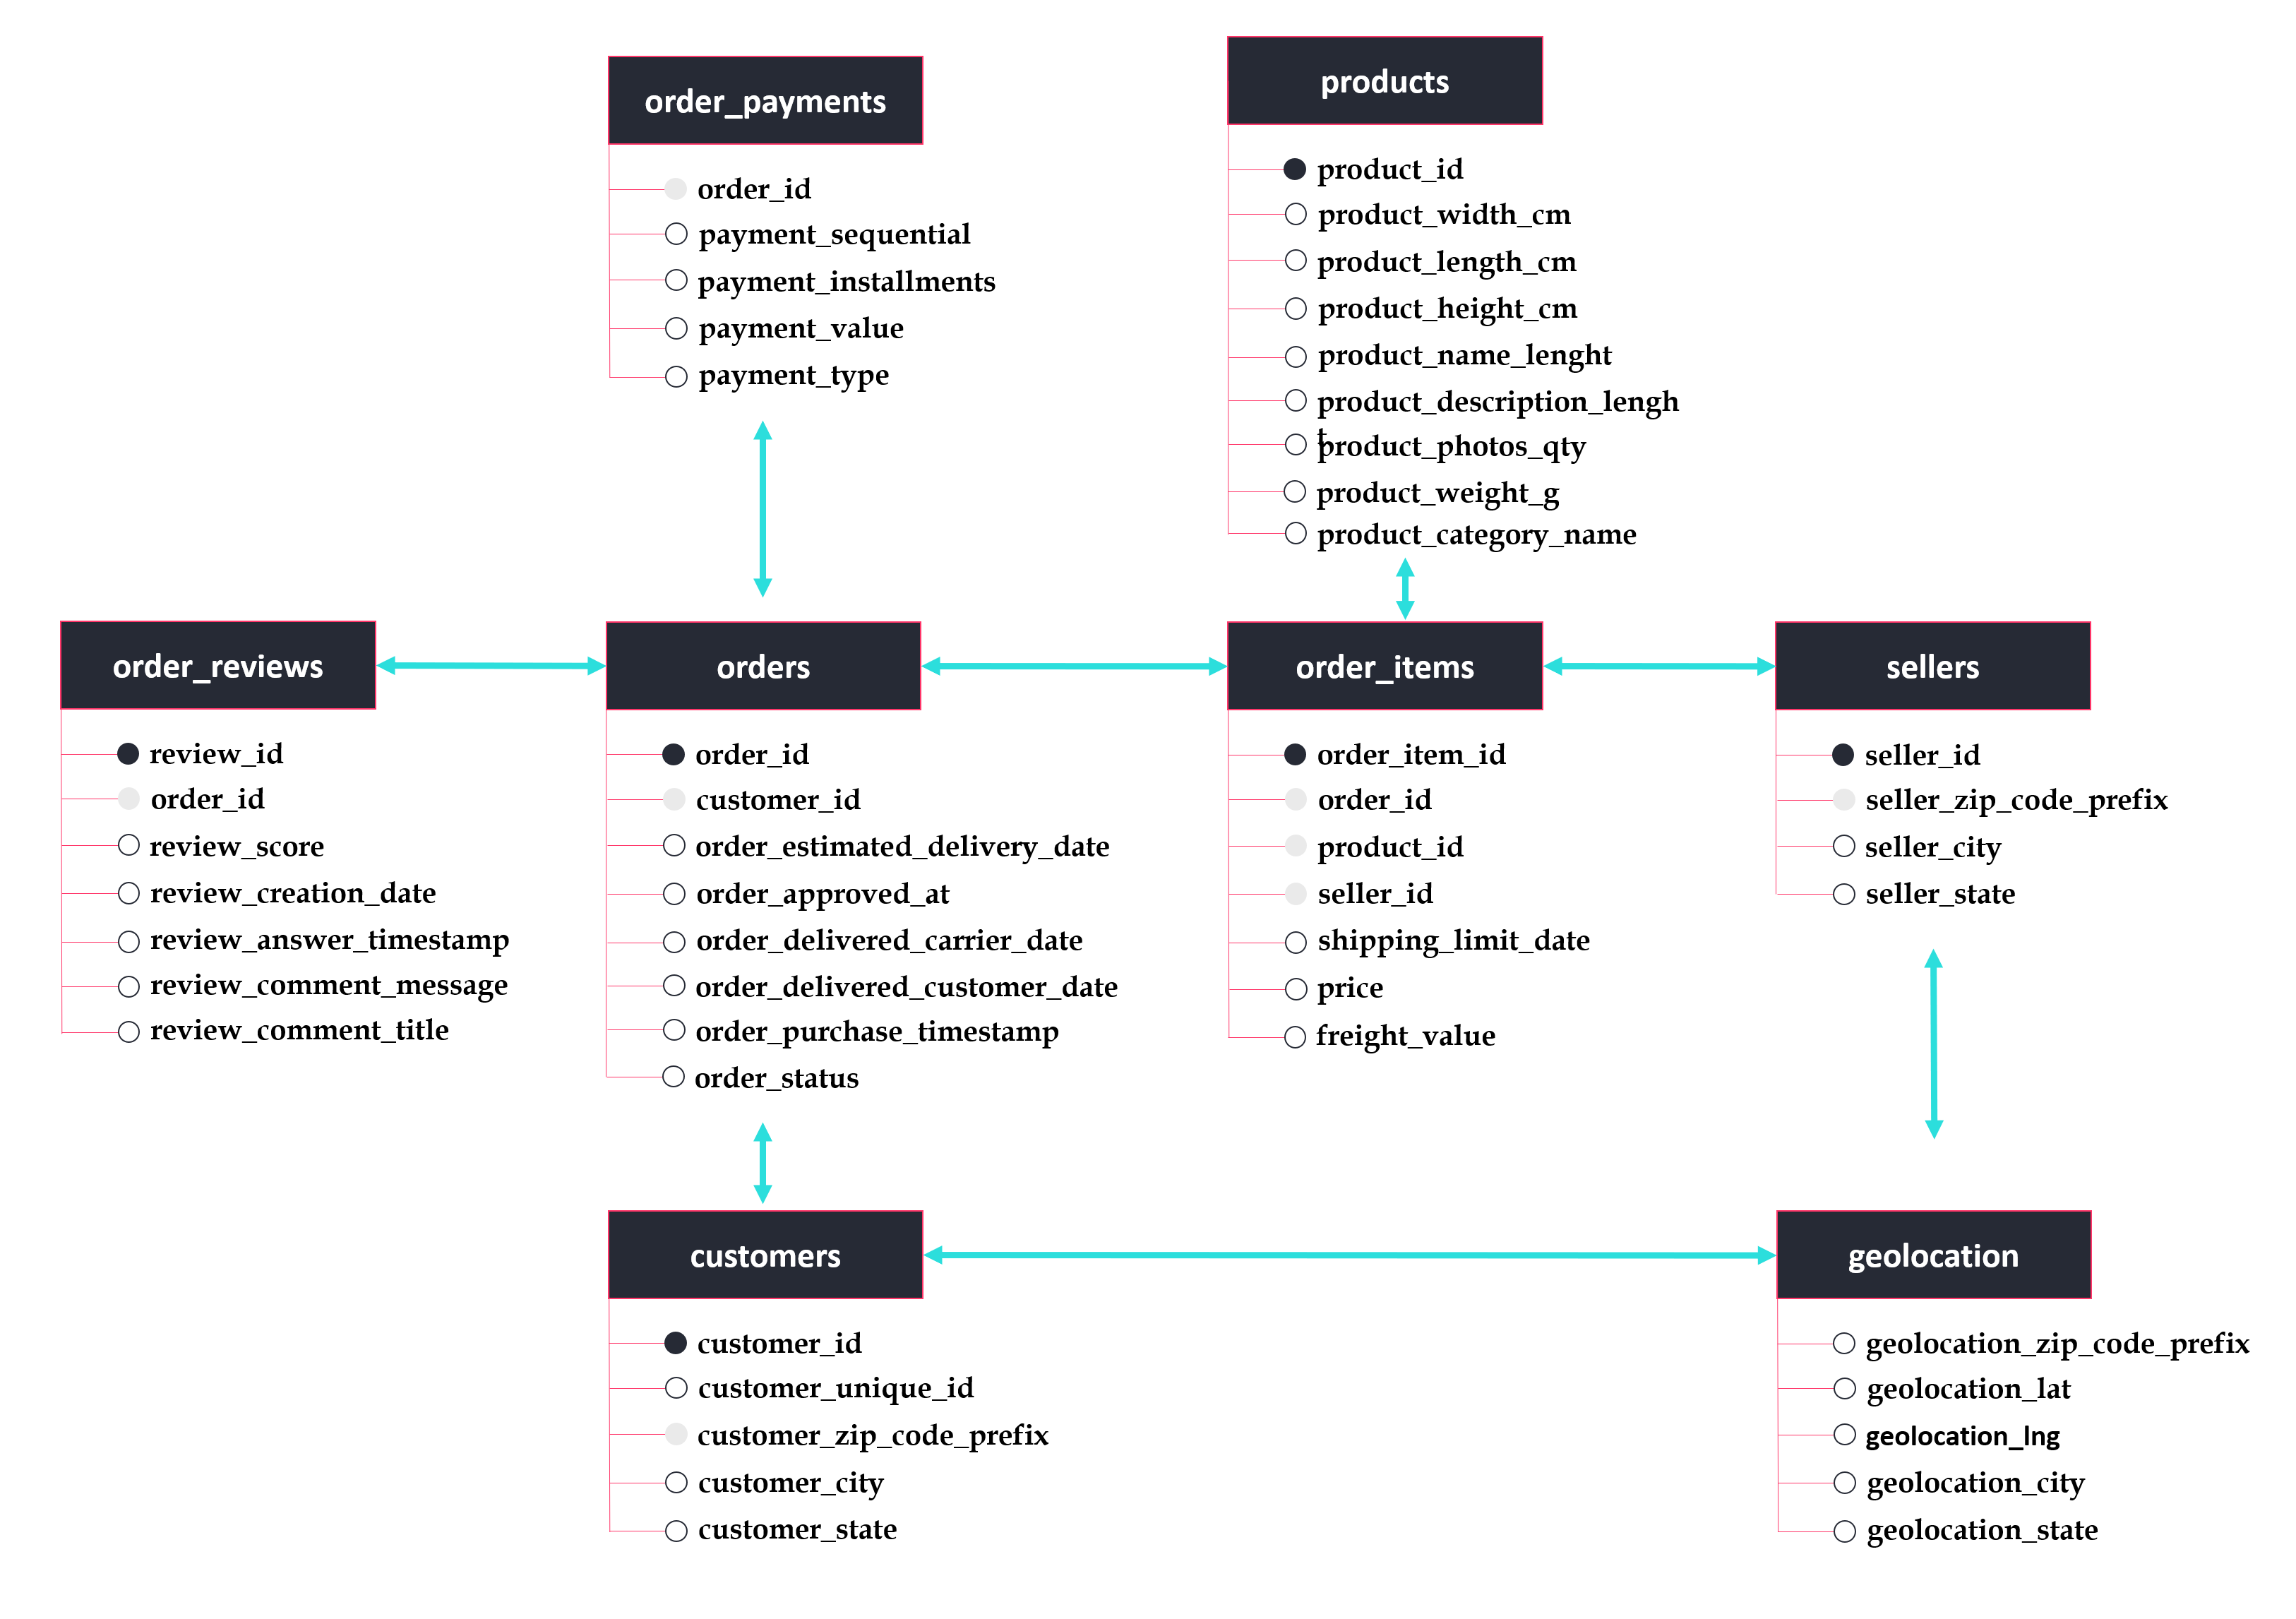

In [26]:
db_mer_schema()

In [448]:
q = '''
SELECT orders.order_id AS order_id,
       order_status AS order_status,
       order_approved_at AS order_approved_at,
       order_purchase_timestamp as purchase_date,
       price AS price,
       freight_value AS freight,
       order_items.seller_id AS seller_id,
       seller_state AS seller_state,
       seller_city AS seller_city
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
            LEFT JOIN sellers ON order_items.seller_id = sellers.seller_id;'''
# WHERE order_purchase_timestamp >= DATE('2018-01-01')

cols = ['order_id','order_status','order_approved_at','purchase_date', 
        'price','freight','seller_id','seller_state','seller_city']
sellers_productivity_df = to_pandas(db.execute(q), cols)

In [449]:
print(len(sellers_productivity_df.seller_id.unique()), "Sellers")

3096 Sellers


**Less than 1% missing values and all of them in the same rows. Let's just drop them.**

In [450]:
describe_data(sellers_productivity_df)

Shape: (113425, 9)
Duplicates: True


,data_types,nan_count,nan_percentage
order_id,object,0,0.000000
order_status,object,0,0.000000
order_approved_at,datetime64[ns],161,0.141944
purchase_date,datetime64[ns],0,0.000000
price,float64,775,0.683271
freight,float64,775,0.683271
seller_id,object,775,0.683271
seller_state,object,775,0.683271
seller_city,object,775,0.683271


Shape: (113425, 9)
Duplicates: True


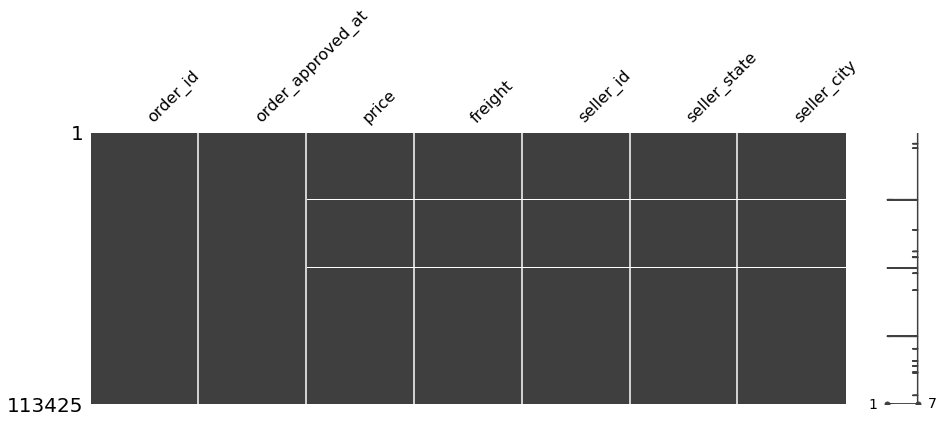

In [451]:
nan_cols = list(describe_data(sellers_productivity_df).query('nan_percentage > 0').index)
missing_plot(sellers_productivity_df, nan_cols, "order_id", second_graph=False)

In [452]:
sellers_productivity_df.dropna(inplace=True)

**Creating RFV Table**

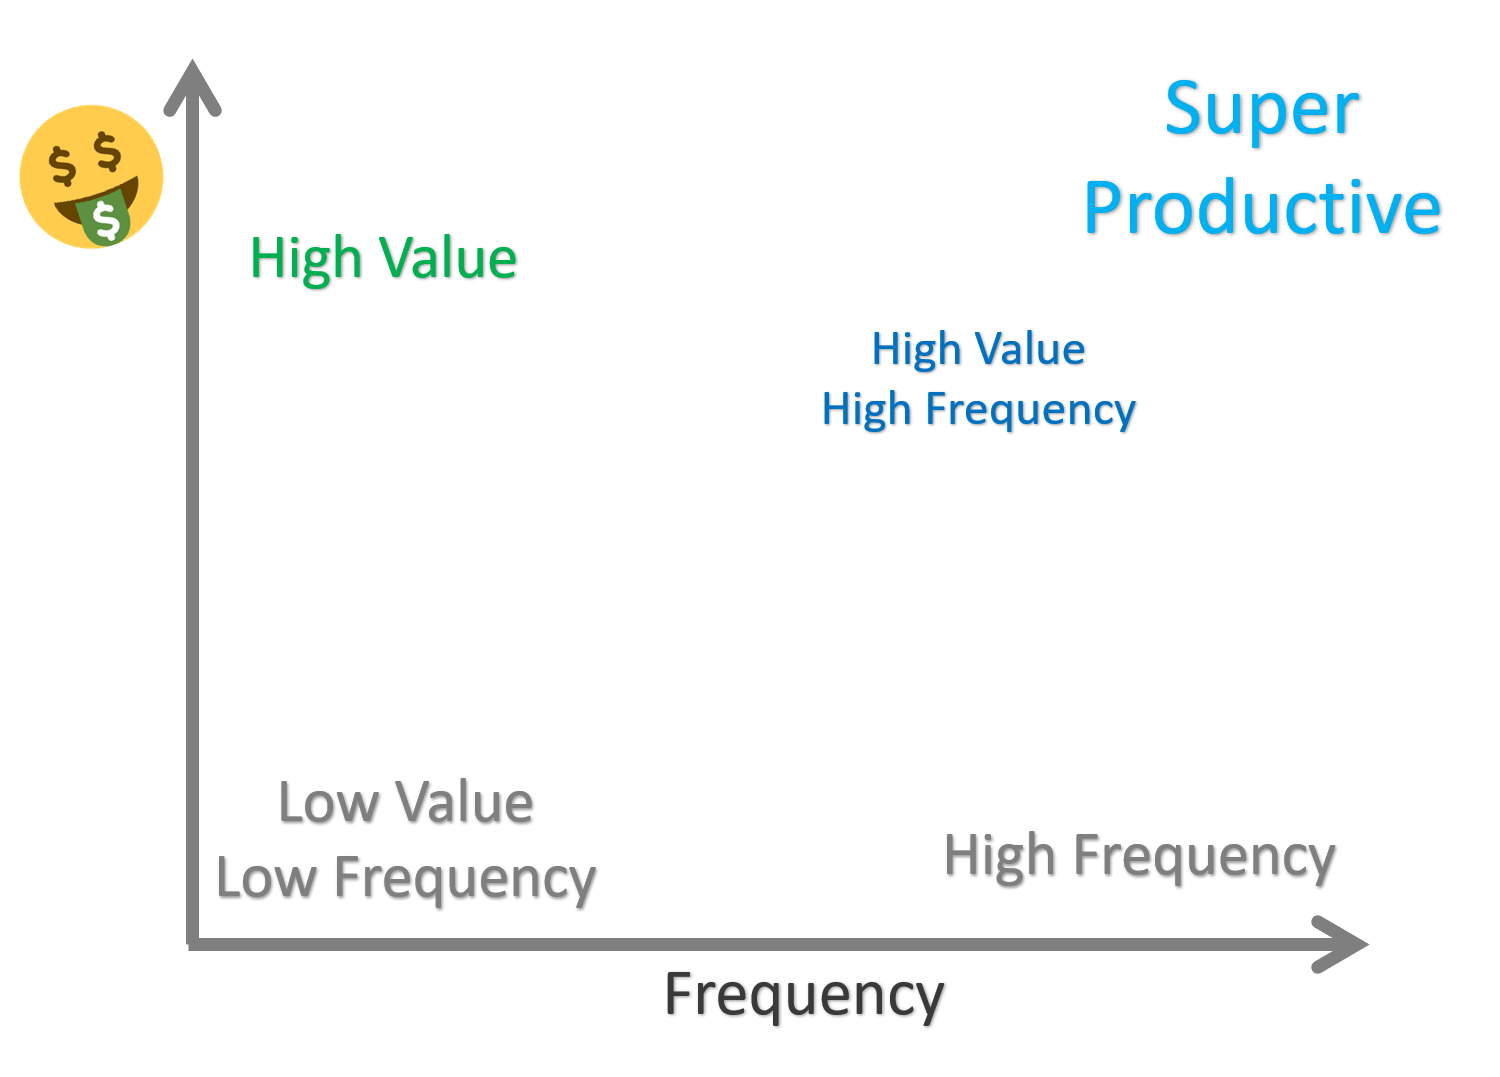

In [513]:
Image("../images/type_of_sellers.PNG", width=500)

In [438]:
# amount_sold_brl revenue Value*
sellers_productivity_df.groupby("seller_id")["price"].sum()      
# sales_quantity "False Frequency"
sellers_productivity_df.groupby("seller_id")["order_id"].count()    
# distinct_products_quantity
sellers_productivity_df.groupby("seller_id")["order_id"].nunique() 
# days_since_last_sale Recency*
pd.to_datetime(sellers_productivity_df.groupby("seller_id")["order_approved_at"].max()).dt.date.apply(lambda x: NOWADAY - x)
# days_since_first_sale
pd.to_datetime(sellers_productivity_df.groupby("seller_id")["order_approved_at"].min()).dt.date.apply(lambda x: NOWADAY - x)
# Frequency*

# amount_sold_brl revenue percentile rank
sellers_productivity_df.groupby("seller_id")["price"].sum().rank(pct=True)
#
sellers_productivity_df.groupby("seller_id")["order_id"].count().rank(pct=True)   


In [518]:
value_rank = sellers_productivity_df.groupby("seller_id")["price"].sum().rank(pct=True)
v = sellers_productivity_df.groupby("seller_id")["price"].sum()

In [519]:
# Frequency as Number of Purchases
frequency_rank = sellers_productivity_df.groupby("seller_id")["order_id"].count().rank(pct=True)
f = sellers_productivity_df.groupby("seller_id")["order_id"].count()

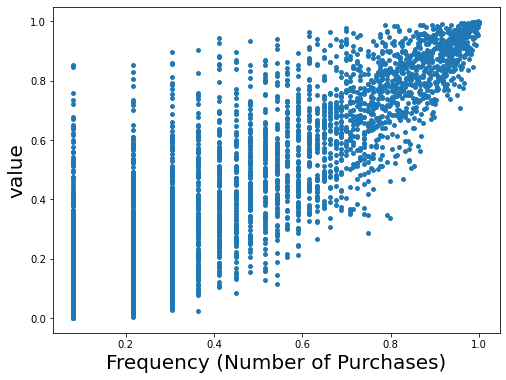

In [520]:
fig(8,6)
plt.xlabel('Frequency (Number of Purchases)', size=20)
plt.ylabel('value', size=20)
plt.scatter(frequency_rank, value_rank, s=15);

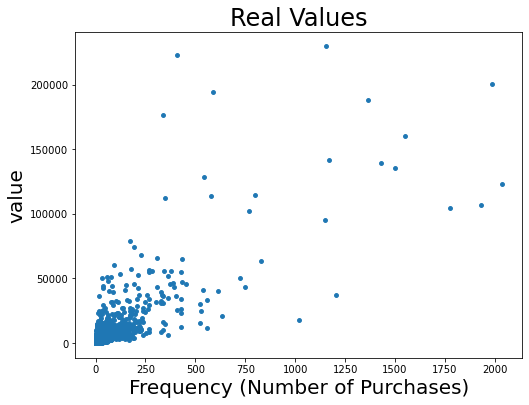

In [521]:
fig(8,6)
plt.title("Real Values", size=24)
plt.xlabel('Frequency (Number of Purchases)', size=20)
plt.ylabel('value', size=20)
# plt.xlim(-10,1000)
# plt.ylim(0,50000)
plt.scatter(f, v, s=15);

In [530]:
# Quantity of Days Divided by Number of Purchases
frequency_rank = (pd.to_datetime(sellers_productivity_df.groupby("seller_id")["order_approved_at"].min()).dt.date.\
                  apply(lambda x: NOWADAY - x) /
                  sellers_productivity_df.groupby("seller_id")["order_id"].count()).rank(pct=True)
f = (pd.to_datetime(sellers_productivity_df.groupby("seller_id")["order_approved_at"].min()).dt.date.\
                  apply(lambda x: NOWADAY - x) /
                  sellers_productivity_df.groupby("seller_id")["order_id"].count()).dt.days

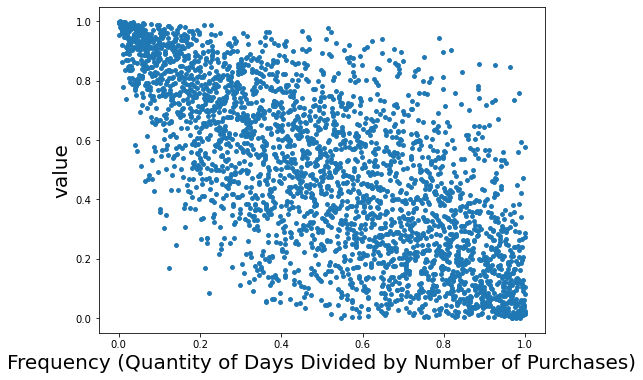

In [531]:
fig(8,6)
plt.xlabel('Frequency (Quantity of Days Divided by Number of Purchases)', size=20)
plt.ylabel('value', size=20)
plt.scatter(frequency_rank,value_rank, s=15);

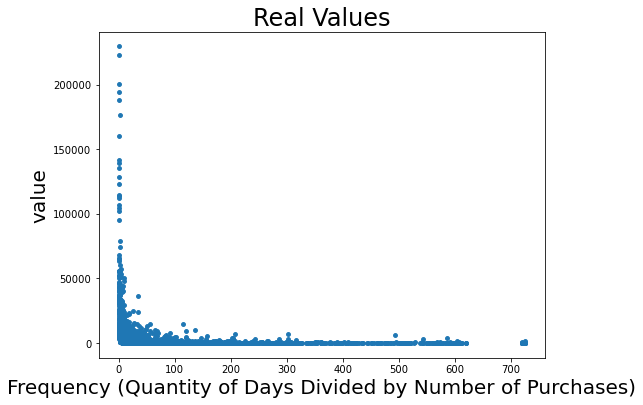

In [532]:
fig(8,6)
plt.title("Real Values", size=24)
plt.xlabel('Frequency (Quantity of Days Divided by Number of Purchases)', size=20)
plt.ylabel('value', size=20)
# plt.xlim(-10,1000)
# plt.ylim(0,50000)
plt.scatter(f, v, s=15);

In [564]:
# Quantity of Months Divided by Number of Purchases
frequency_rank = (pd.to_datetime(sellers_productivity_df.groupby("seller_id")["order_approved_at"].min()).dt.date.\
                  apply(lambda x: NOWADAY - x)/30 /
                  sellers_productivity_df.groupby("seller_id")["order_id"].count()).rank(pct=True)
f = (pd.to_datetime(sellers_productivity_df.groupby("seller_id")["order_approved_at"].min()).dt.date.\
                  apply(lambda x: NOWADAY - x)/30 /
                  sellers_productivity_df.groupby("seller_id")["order_id"].count()).dt.days

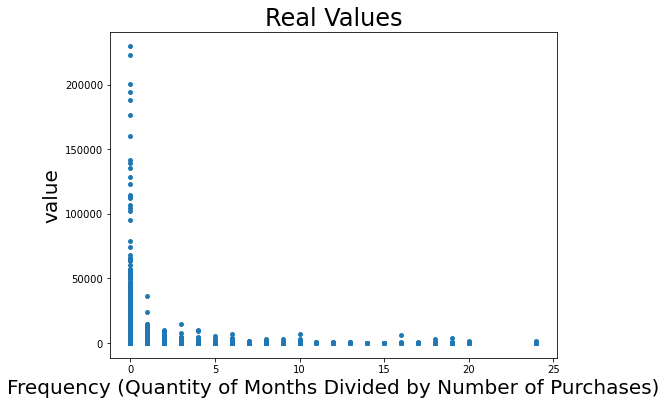

In [565]:
fig(8,6)
plt.title("Real Values", size=24)
plt.xlabel('Frequency (Quantity of Months Divided by Number of Purchases)', size=20)
plt.ylabel('value', size=20)
# plt.xlim(-10,1000)
# plt.ylim(0,50000)
plt.scatter(f, v, s=15);

In [ ]:
# write_query("../sql_queries/total_sales_per_month", query_)

### 2.2 Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?

### 2.3 Is our product catalog comprehensive? Or does it focus on specific categories?

### 2.4 Do we always sell the same products? Or are there seasonalities?

In [21]:
# locations = pd.DataFrame(db.execute("SELECT geolocation_state, geolocation_lat, geolocation_lng FROM geolocation;"),
#                          columns=['state','lat','lng'])
# locations['region'] = locations.state.apply(map_regions)

# fig(15, 15)
# sns.scatterplot(data=locations, x='lng', y='lat', hue='region')
# plt.xlim(-75, -30)
# plt.ylim(-40, 10);


# Business Questions. 
_We want answers!_ 

**The company's business areas have some doubts and challenges such as:**


- Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?


- Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?


- Is our product catalog comprehensive? Or does it focus on specific categories?


- Do we always sell the same products? Or are there seasonalities?



**Dashboard that analyzes the company's latest sales data that can be shared with Regional leads and their respective analysts:**

- Total Sales
- Sales per Region
- Top 5 selling categories for each Region


**We also need to know:**

> Number of Orders Per Day.
>
> Number of Orders per city.
>
> Number of Orders by Payment Method.

- What is the revenue for each product category? What about total sales, in units and in orders?
- What is the total amount of revenue generated by customers in each state? 
- What is the total amount of revenue generated by sellers in each state?

_delivered orders only_